In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
import seaborn as sns

/home/seb/py36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


The data for England and Wales (as well as sub-regions, such as London) can be accessed from the Office of National Statistics here: https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales

See the notebook `_1_ingest_process_excel` for various caveats on the UK data

In [2]:
wdir = '../data/processed'

In [3]:
df_all = pd.read_csv(wdir + '/deaths_2020_wk15.csv').iloc[:15,:].reset_index(drop=True).copy(deep=True)
df_all = df_all[['week', 'week_ended', 'total_deaths_all_ages', 'total_deaths_avg_corresponding_5', 'respitory_deaths', 'london', 'south_east']]

df_covid = pd.read_csv(wdir + '/deaths_2020_wk15_covid.csv').iloc[:15,:].reset_index(drop=True).copy(deep=True)
df_covid = df_covid[['week', 'covid_deaths', 'london', 'south_east']]
df_covid.columns = ['week', 'covid_deaths', 'london_covid', 'south_east_covid']
df_2020 = pd.merge(df_all, df_covid, on=['week'], how='inner').iloc[10:,:].reset_index(drop=True).copy(deep=True)
df_2020 = df_2020[['week', 'week_ended', 'total_deaths_all_ages', 'covid_deaths', 'london', 'london_covid']]
df_2020.columns = ['week', 'week_ended', '2020_ew', '2020_ew_covid', '2020_lon', '2020_lon_covid']

In [4]:
for y in range(2015, 2020):
    df_y = pd.read_csv(wdir + '/deaths_{}.csv'.format(y)).iloc[:15,:].reset_index(drop=True)[['week', 'london']].copy(deep=True)
    df_y.columns = ['week', '{}_lon'.format(y)]
    df_y_alldeath = pd.read_csv(wdir + '/deaths_{}.csv'.format(y)).iloc[:15,:].reset_index(drop=True)[['week', 'total_deaths_all_ages']].copy(deep=True)
    df_y_alldeath.columns = ['week', '{}_ew'.format(y)]
    
    if y == 2015:
        df_lon = df_y.copy(deep=True)
        df_alldeath = df_y_alldeath.copy(deep=True)
    else:
        df_lon = pd.merge(df_lon, df_y, on=['week'], how='inner')
        df_alldeath = pd.merge(df_alldeath, df_y_alldeath, on=['week'], how='inner')
df = pd.merge(df_2020, df_alldeath, on=['week'], how='inner')
df = pd.merge(df, df_lon, on=['week'], how='inner')

compute cumulative totals

In [5]:
for i in range(2015, 2021):
    df['cs_ew_{}'.format(i)] = df['{}_ew'.format(i)].cumsum()
    df['cs_lon_{}'.format(i)] = df['{}_lon'.format(i)].cumsum()
    del df['{}_lon'.format(i)]
    del df['{}_ew'.format(i)]
df['cs_ew_covid'] = df['2020_ew_covid'].cumsum()
df['cs_lon_covid'] = df['2020_lon_covid'].cumsum()
df = df.drop(['2020_ew_covid', '2020_lon_covid'], axis=1)

compute growth rates

In [6]:
for yr in range(2015, 2020):
    df['gr_ew_{}'.format(yr)] = df['cs_ew_{}'.format(yr)] / df['cs_ew_{}'.format(yr)].shift(1)
    df['gr_lon_{}'.format(yr)] = df['cs_lon_{}'.format(yr)] / df['cs_lon_{}'.format(yr)].shift(1)
    del df['cs_lon_{}'.format(yr)]
    del df['cs_ew_{}'.format(yr)]

compute average of growth rates

In [7]:
df['weekly_growth_ew'] = df.loc[:,['gr_ew_{}'.format(yr) for yr in range(2015,2020)]].mean(axis=1)
df['weekly_growth_lon'] = df.loc[:,['gr_lon_{}'.format(yr) for yr in range(2015,2020)]].mean(axis=1)
df = df.drop(['gr_ew_{}'.format(yr) for yr in range(2015,2020)], axis=1)
df = df.drop(['gr_lon_{}'.format(yr) for yr in range(2015,2020)], axis=1)

extrapolating forward

In [8]:
df['ew_extrap'] = 0
df['lon_extrap'] = 0

df.loc[0, 'ew_extrap'] = df.cs_ew_2020[0]
df.loc[0, 'lon_extrap'] = df.cs_lon_2020[0]

for i in range(1, df.shape[0]):
    df.loc[i, 'ew_extrap'] = df.loc[i-1, 'ew_extrap'] * df.loc[i, 'weekly_growth_ew']
    df.loc[i, 'lon_extrap'] = df.loc[i-1, 'lon_extrap'] * df.loc[i, 'weekly_growth_lon']
    
df['ew_extrap_covid'] = df.ew_extrap + df.cs_ew_covid
df['lon_extrap_covid'] = df.lon_extrap + df.cs_lon_covid

selecting the right variables and constructing a date column

In [9]:
df_ew = df[['week', 'week_ended', 'cs_ew_covid', 'cs_ew_2020', 'ew_extrap', 'ew_extrap_covid']].copy(deep=True)
df_ew.columns = ['week', 'week_ended', 'covid_deaths', 'deaths_2020', '2020_counterfactual', 'counterfactual_plus_covid']
df_ew['date'] = df_ew.week_ended.astype('str').str[:10]
df_ew['date']  =  pd.to_datetime(df_ew['date'] , format='%Y%m%d', errors='ignore')
df_ew = df_ew.drop(['week', 'week_ended'], axis=1)
df_ew.index = df_ew.date
del df_ew['date']

In [10]:
df_lon = df[['week', 'week_ended', 'cs_lon_covid', 'cs_lon_2020', 'lon_extrap', 'lon_extrap_covid']].copy(deep=True)
df_lon.columns = ['week', 'week_ended', 'covid_deaths', 'deaths_2020', '2020_counterfactual', 'counterfactual_plus_covid']
df_lon['date'] = df_lon.week_ended.astype('str').str[:10]
df_lon['date']  =  pd.to_datetime(df_lon['date'] , format='%Y%m%d', errors='ignore')
df_lon = df_lon.drop(['week', 'week_ended'], axis=1)
df_lon.index = df_lon.date
del df_lon['date']

# Plotting

## England and Wales

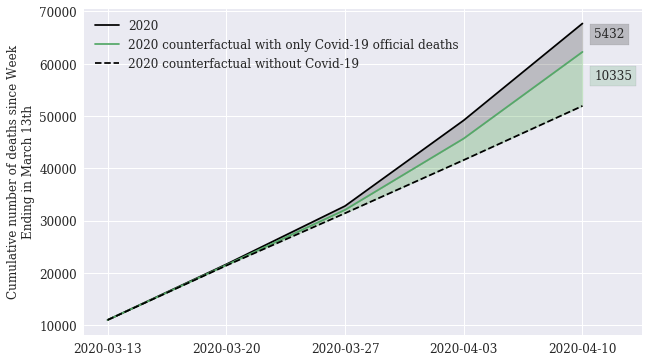

In [11]:
palette = sns.color_palette()

f = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)

ax.plot(df_ew.index,
        df_ew['deaths_2020'],
        label='2020',
        color='black')
ax.plot(df_ew.index,
        df_ew['counterfactual_plus_covid'],
        label='2020 counterfactual with only Covid-19 official deaths',
        color = palette[1])
ax.plot(df_ew.index,
        df_ew['2020_counterfactual'],
        label='2020 counterfactual without Covid-19',
        color='black', 
        linestyle = '--')
ax.set_xticks(df_ew.index[[0,1,2,3,4]])
ax.fill_between(df_ew.index, df_ew['deaths_2020'], df_ew['counterfactual_plus_covid'], color='black', alpha='0.2')
ax.fill_between(df_ew.index, df_ew['counterfactual_plus_covid'], df_ew['2020_counterfactual'], color='green', alpha='0.2')

ax.set_ylabel('Cumulative number of deaths since Week\nEnding in March 13th',size=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(loc='upper left',
          fontsize=12)

plot_margin = 0.3

x0, x1, y0, y1 = plt.axis()
plt.axis((x0,
          x1 + plot_margin,
          y0,
          y1))

plt.text(4.1, 57000, '{}'.format(int(round(df_ew.iloc[-1, 3] - df_ew.iloc[-1, 2]))),
         bbox=dict(facecolor=palette[1], alpha=0.2), size=12)

plt.text(4.1, 65000, '{}'.format(int(round(df_ew.iloc[-1, 1] - df_ew.iloc[-1, 3]))),
         bbox=dict(facecolor='black', alpha=0.2), size=12)

plt.show()

f.savefig(wdir+'/../../_englandwales.pdf', bbox_inches='tight', dpi=100)

In [12]:
print('Official covid-deaths: {} = green - dashed black'.format(round(df_ew.iloc[-1, 3] - df_ew.iloc[-1, 2])))
print('Excess deaths: {} = solid black - dashed black'.format(round(df_ew.iloc[-1, 1] - df_ew.iloc[-1, 2])))
print('Unexplained excess deaths: {} = solid black - green'.format(round(df_ew.iloc[-1, 1] - df_ew.iloc[-1, 3])))

Official covid-deaths: 10335.0 = green - dashed black
Excess deaths: 15767.0 = solid black - dashed black
Unexplained excess deaths: 5432.0 = solid black - green


## London

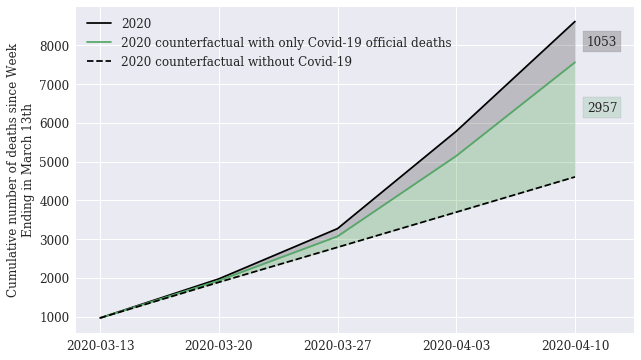

In [13]:
palette = sns.color_palette()

f = plt.figure(figsize=(10,6))
ax = plt.subplot(1,1,1)

ax.plot(df_lon.index,
        df_lon['deaths_2020'],
        label='2020',
        color='black')
ax.plot(df_lon.index,
        df_lon['counterfactual_plus_covid'],
        label='2020 counterfactual with only Covid-19 official deaths',
        color = palette[1])
ax.plot(df_lon.index,
        df_lon['2020_counterfactual'],
        label='2020 counterfactual without Covid-19',
        color='black', 
        linestyle = '--')
ax.set_xticks(df_lon.index[[0,1,2,3,4]])
ax.fill_between(df_lon.index, df_lon['deaths_2020'], df_lon['counterfactual_plus_covid'], color='black', alpha='0.2')
ax.fill_between(df_lon.index, df_lon['counterfactual_plus_covid'], df_lon['2020_counterfactual'], color='green', alpha='0.2')

ax.set_ylabel('Cumulative number of deaths since Week\nEnding in March 13th',size=12)
ax.tick_params(axis='both', which='major', labelsize=12)

ax.legend(loc='upper left',
          fontsize=12)

plot_margin = 0.3

x0, x1, y0, y1 = plt.axis()
plt.axis((x0,
          x1 + plot_margin,
          y0,
          y1))

plt.text(4.1, 6300, '{}'.format(int(round(df_lon.iloc[-1, 3] - df_lon.iloc[-1, 2]))),
         bbox=dict(facecolor=palette[1], alpha=0.2), size=12)

plt.text(4.1, 8000, '{}'.format(int(round(df_lon.iloc[-1, 1] - df_lon.iloc[-1, 3]))),
         bbox=dict(facecolor='black', alpha=0.2), size=12)

plt.show()

f.savefig(wdir+'/../../_london.pdf', bbox_inches='tight', dpi=100)

In [14]:
print('Official covid-deaths: {} = green - dashed black'.format(round(df_lon.iloc[-1, 3] - df_lon.iloc[-1, 2])))
print('Excess deaths: {} = solid black - dashed black'.format(round(df_lon.iloc[-1, 1] - df_lon.iloc[-1, 2])))
print('Unexplained excess deaths: {} = solid black - green'.format(round(df_lon.iloc[-1, 1] - df_lon.iloc[-1, 3])))

Official covid-deaths: 2957.0 = green - dashed black
Excess deaths: 4010.0 = solid black - dashed black
Unexplained excess deaths: 1053.0 = solid black - green
